In [34]:
import numpy as np
import pandas as pd
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import cv2
import matplotlib.pyplot as plt

In [2]:
# # Size of images
# folder_path = Path('maze/unsolvable')
# for img_path in folder_path.glob('*.png'):
#     with Image.open(img_path) as img:
#         print(img.size)  # This will print the dimensions of the image
#         break  # Just check the first one for now

In [53]:
# Define paths to the folders
solvable_path = Path('./31')
unsolvable_path = Path('./31_unsolvable_same_wall_count')
max_images = 15000  # Total number of images to load (50% solvable + 50% unsolvable)

# Calculate the number of images to load per class
images_per_class = max_images // 2

images = []  # Initialize a list to store image data
labels = []  # Initialize a list to store labels

# Function to load and flatten images from a folder, and assign labels
def load_and_label_images(folder_path, label, max_images):
    count = 0
    for img_path in folder_path.glob('*.png'):
        if count >= max_images:
            break
        img_array = np.array(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
        img_flat = img_array.flatten()  # Flatten the 2D image to 1D
        img_flat = img_flat.astype(int)  # Convert boolean values to integers
        images.append(img_flat)
        labels.append(label)
        count += 1

# Load and label an equal number of solvable and unsolvable images
load_and_label_images(solvable_path, 1, images_per_class)  # Label 1 for solvable
load_and_label_images(unsolvable_path, 0, images_per_class)  # Label 0 for unsolvable

# Create a DataFrame
df = pd.DataFrame(images)
df['Label'] = labels  # Add the labels column

In [54]:
# Data preparation
X = df.drop('Label', axis=1).values
y = df['Label'].values

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction with PCA
#pca = PCA(n_components=0.95)  # Retain 95% of variance
#X_pca = pca.fit_transform(X_scaled)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SVM Classifier
#clf = svm.SVC(kernel='rbf')
#clf.fit(X_train, y_train)

# Predictions
#y_pred = clf.predict(X_test)

In [5]:
# Accuracy
#accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy)

# Confusion Matrix
#conf_matrix = confusion_matrix(y_test, y_pred)
#print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.521
Confusion Matrix:
 [[ 990 1495]
 [ 900 1615]]


In [ ]:
# Set up parameter grid to test different configurations
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],  # Kernel Coefficients
    'degree': [2, 3, 4]  # Degree of the polynomial kernel, if polynomial is selected
}

# Create a GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Evaluate the best model found by GridSearchCV
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Best Model's Params:", grid_search.best_params_)
print("Best Model's Accuracy:", best_model.score(X_test, y_test))

In [55]:
# The best kernel type is sigmoid. Test different configurations of only the parameters for this kernel type
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['sigmoid'],
    'gamma': [0.001, 0.01, 0.1],  # Kernel Coefficients
}
# There are 5 times 4 = 20 configurations, so this will take about 20 times as long as training the model once. 

# Create a GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)

# Evaluate the best model found by GridSearchCV
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Best Model's Params:", grid_search.best_params_)
print("Best Model's Accuracy:", best_model.score(X_test, y_test))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=  56.3s
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=  56.0s
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=  56.1s
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=  56.3s
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=  58.2s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=  59.3s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=  56.6s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=  57.1s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=  58.4s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=  57.6s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=  51.0s
[CV] END ...................C=0.1, gamma=0.1, ker

In [56]:
nu_clf = svm.SVC(C=1, gamma=0.01, kernel='sigmoid')
nu_clf.fit(X_train, y_train)

# Predictions
y_pred = nu_clf.predict(X_test)

In [57]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7656666666666667
Confusion Matrix:
 [[1136  357]
 [ 346 1161]]


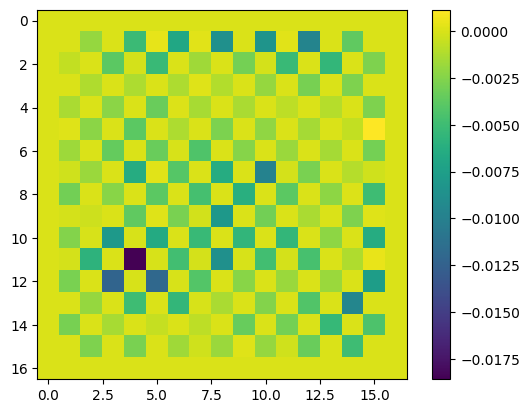

In [49]:
# identify important features and plot importance heatmap (17 by 17)
perm_importance = permutation_importance(nu_clf, X_train, y_train, n_jobs=8)
importances = perm_importance['importances_mean'].reshape(17, 17)
ax = plt.imshow(importances, cmap='viridis')
_ = plt.colorbar(ax)